Loads a .h5 model and evaluates its performance 

R. Dogaru 4 feb. 2021 
=====================

In [1]:
# Datasets from Keras - MNIST, F_MNIST, CIFAR 
#---------------------------------------------------


import numpy as np
import keras 

dataset='mnist' # mnist or f-mnist or cifar10 
reduced=0
dformat='channels_last'

from keras.datasets import mnist, cifar10, cifar100, fashion_mnist

if dataset=='mnist':
    (x_train, y_train), (x_test, y_test) = mnist.load_data() # incarca date nescalate 
elif  dataset=='cifar10': 
    (x_train, y_train), (x_test, y_test) = cifar10.load_data() # incarca date nescalate 
elif  dataset=='cifar100': 
    (x_train, y_train), (x_test, y_test) = cifar100.load_data() # incarca date nescalate 
elif dataset=='f-mnist':
    (x_train, y_train), (x_test, y_test) =  fashion_mnist.load_data()

if (np.ndim(x_train)==3):   # E.g.  MNIST or F-MNIST  
    x_train=np.reshape(x_train, [np.shape(x_train)[0],np.shape(x_train)[1],np.shape(x_train)[2], 1]) 
    x_test=np.reshape(x_test, [np.shape(x_test)[0],np.shape(x_test)[1],np.shape(x_test)[2], 1] ) 
# place a  1 in the end to keep it compatible with kernel in conv2d 
# scaling in ([0,1])
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /=255 
inp_chan=np.shape(x_train)[3] 
print('Number of input channels in image:', inp_chan)
num_classes=np.max(y_train)+1
num_inputs = np.shape(x_test)[1]
input_shape=np.shape(x_train)[1:4]


# one can choose a lower numbers of training samples (when GPU MEM is overloaded)
if reduced>0:
    Ntr1=reduced
    x_train=x_train[0:Ntr1,:,:,:]
    y_train=y_train[0:Ntr1]
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11493376/11490434 [==============================] - 0s 0us/step
Number of input channels in image: 1


In [72]:
from keras.models import load_model
model=load_model('blcnn_mnist_99_28_9bit.h5')  # please check in advance to have the dataset already loaded 

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_13 (Sequential)   (None, 32768)             29952     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                327690    
Total params: 357,642
Trainable params: 327,690
Non-trainable params: 29,952
_________________________________________________________________


In [73]:
allw=model.get_weights()
lay=np.shape(allw)[0]
print('there are: ', lay-2, 'binary convolutional layers plus ',2,'weights + biases output layer') 

for i in range(lay):
  tsize=(np.shape(allw[i]))
  print('Layer  ', i, ' structure is: ', tsize)
  print('Min ',np.min(allw[i]), '  Max ', np.max(allw[i]))
  

there are:  3 binary convolutional layers plus  2 weights + biases output layer
Layer   0  structure is:  (3, 3, 1, 256)
Min  -1.0   Max  1.0
Layer   1  structure is:  (3, 3, 256, 4)
Min  -1.0   Max  1.0
Layer   2  structure is:  (3, 3, 1024, 2)
Min  -1.0   Max  1.0
Layer   3  structure is:  (32768, 10)
Min  -245.0   Max  185.0
Layer   4  structure is:  (10,)
Min  -4.0   Max  7.0


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [77]:
# inspect the content of a certain layer 
allw[4]

array([ 6.,  7., -2., -3.,  1., -1.,  3.,  3., -4., -1.], dtype=float32)

In [74]:
import time as ti
t1=ti.time()
score = model.evaluate(x_test, y_test, verbose=0)
t2=ti.time()
print('Test accuracy:', 100*score[1], ' % ')
print ('Time for test set : ',t2-t1)
print('Latency / sample:  ', 1000*(t2-t1)/np.shape(x_test)[0], ' mili seconds')


Test accuracy: 99.27999973297119  % 
Time for test set :  15.237890005111694
Latency / sample:   1.5237890005111694  mili seconds


Eticheta originala: 3.0
Eticheta recunoscuta:  3


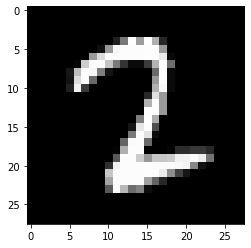

In [75]:
# VIZUALIZARE EXEMPLE 

selectia=int(np.shape(x_test)[0]*np.random.rand(1))  # 

img1=x_test[selectia,:,:,:]
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
if np.shape(x_train)[3]==1:
  plt.imshow(img1[:,:,0],cmap='gray')
elif np.shape(x_train)[3]==3:
  plt.imshow(img1)

label=np.dot(y_test[selectia,:],1+np.array(range(num_classes)).T)
print('Eticheta originala:', label)
z=model.predict(x_test[selectia:selectia+1,:,:,:])
print('Eticheta recunoscuta: ',1+np.argmax(z))



In [76]:
# Evaluare matrice de confuzie si performamnte de clasificare 
# Permite sa evaluam care clasa are acuratetea mai mica etc.. 
#----------------------------------------------------------------

labels=(np.dot(y_test,np.array(range(num_classes)).T)).astype('int16')
pred= model.predict(x_test)
predicted_class_indices=np.argmax(pred,axis=1)
from sklearn.metrics import classification_report, confusion_matrix
C=confusion_matrix(predicted_class_indices,labels)
print (C)
print('Classification Report')
print(classification_report(labels,predicted_class_indices ))


[[ 977    0    1    0    0    1    4    0    2    0]
 [   0 1130    0    0    0    0    1    2    0    0]
 [   0    1 1028    0    0    0    1    3    1    0]
 [   0    1    0 1005    0    3    0    0    0    2]
 [   0    0    0    0  978    0    1    0    0    7]
 [   0    0    0    3    0  886    4    0    0    1]
 [   0    2    0    0    0    1  944    0    0    0]
 [   1    1    3    0    0    0    0 1020    2    4]
 [   2    0    0    2    0    0    3    1  967    2]
 [   0    0    0    0    4    1    0    2    2  993]]
Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      1.00      1.00      1135
           2       0.99      1.00      1.00      1032
           3       0.99      1.00      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7  